In [51]:
#! usr/bin/env python3

import cv2
import pytesseract
from matplotlib import pyplot as plt

In [52]:
image_path1 = 'Reciepts/20240121_123406.jpg'
image_path2 = 'Reciepts/Screenshot_20240119_144636_Snapchat.jpg'
image_path3 = 'Reciepts/Screenshot_20240117_130009_Snapchat.jpg'
image_path4 = 'Reciepts/rn_image_picker_lib_temp_b8398417-03be-4526-83c9-6210b1165e38.jpg'
image_path5 = 'Reciepts/remix-99c4d338-30b8-40af-8a60-352cffb20aed.png'
image_path6 = 'Reciepts/image0.jpg'
image_path7 = 'Reciepts/1187818978635173980remix-1703268574721.png'
image = cv2.imread(image_path7)

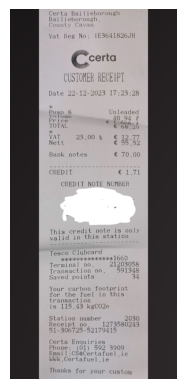

In [53]:
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

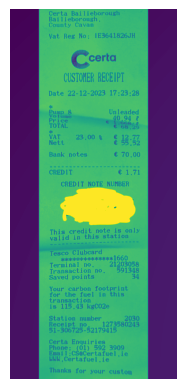

In [54]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [55]:
# image = cv2.bitwise_not(image)
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()

In [56]:
# image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# # plt.show()

In [57]:
text = pytesseract.image_to_string(image)

In [58]:
filtered_text = '\n'.join(
    line for line in text.split('\n') if line.strip() != '')

print(filtered_text)

Certa Bailieborough
Bailieborough ,
County Cavan
Vat Reg No: I1H3641826JH
Cc
STOMER RECEIPT
Date 22-12-2023 17:23:28
Pump 8 Unleaded
be ] ume AQ 9 | ?
Price hace
TOTAL wm eS
*
VAT Z5e00ms% Smeal
Nett € 55 52
Bank notes € 70,00
CREDIT € 1.71
CREDIT NOTE NUMBER
This credit note is only
valid in this station
Tesco Clubcard vm
elokekoockeck 1660
Terminal no, 21203058
Transaction no, 591348
Saved points 34
Your carbon footprint
for the fuel in this
transaction
is 115,43 kgCO2e
Station number 2030
Receipt no, 1273580243
51-306725-52179415
Certa Enquiries
Phone: (01) 592 3909
Email :CS@Certafuel .ie
WWW ,Certafuel ie
Thanks for your custom
